In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


#Load Images

In [6]:
images = np.load('pathmnist.npz')

In [7]:
x_train = images['train_images']
x_test = images['test_images']
y_train = images['train_labels']
y_test = images['test_labels']

In [8]:
x_train.shape

(89996, 28, 28, 3)

In [9]:
y_train.shape

(89996, 1)

In [10]:
x_train.max()

255

In [11]:
y_train.max()

8

#Preprocess Data

In [12]:
x_train = x_train/255
x_test = x_test/255

In [13]:
from tensorflow.keras.utils import to_categorical

In [14]:
#one hot encoding
y_cat_train = to_categorical(y_train)

In [15]:
y_cat_test = to_categorical(y_test)

In [16]:
y_cat_train.shape

(89996, 9)

In [17]:
y_cat_test.shape

(7180, 9)

#Build Model

In [18]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K

In [19]:
shape = 28, 28, 3
num_classes = 9
filters = 32

# Batch normalization, ReLU, and 2D conversion function
def ConvolutionalBlock(x, filters, kernel=1, strides=1):
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = Conv2D(filters, kernel, strides=strides, padding = 'same')(x)

  return x

def DenseBlock(x, num_repeats):
  for _ in range(num_repeats):
    y = ConvolutionalBlock(x, 4*filters)
    y = ConvolutionalBlock(y, filters, 3)
    x = concatenate([y, x])
  return x

def TransitionLayer(x):
  x = ConvolutionalBlock(x, K.int_shape(x)[-1] //2)
  x = AvgPool2D(2, strides=2, padding='same')(x)
  return x

input = Input(shape)
x = Conv2D(64, 7, strides=2, padding='same')(input)
x = MaxPool2D(3, strides=2, padding='same')(x)

for num_repeats in [6, 12, 24, 16]:
  d = DenseBlock(x, num_repeats)
  x = TransitionLayer(d)

x = GlobalAveragePooling2D()(d)
out = Dense(num_classes, activation='softmax', kernel_regularizer='l1')(x)
#tf.keras.layers.Dropout(0.5)
model = Model(input, out)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 7, 7, 64)     0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 7, 7, 64)    256         ['max_pooling2d[0][0]']          
 alization)                                                                                   

#Train Model

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=20)

In [22]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-05)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model.fit(x_train, y_cat_train, batch_size=256, epochs=30, validation_data=(x_test, y_cat_test), callbacks=[early_stop])

Epoch 1/30
352/352 [==============================] - 112s 235ms/step - loss: 4.6935 - accuracy: 0.5277 - val_loss: 5.7496 - val_accuracy: 0.2543
Epoch 2/30
352/352 [==============================] - 77s 218ms/step - loss: 4.0533 - accuracy: 0.6624 - val_loss: 4.0954 - val_accuracy: 0.6297
Epoch 3/30
352/352 [==============================] - 76s 215ms/step - loss: 3.6860 - accuracy: 0.7034 - val_loss: 3.8391 - val_accuracy: 0.6390
Epoch 4/30
352/352 [==============================] - 76s 215ms/step - loss: 3.3687 - accuracy: 0.7317 - val_loss: 3.5093 - val_accuracy: 0.6772
Epoch 5/30
352/352 [==============================] - 75s 214ms/step - loss: 3.0820 - accuracy: 0.7510 - val_loss: 3.2424 - val_accuracy: 0.6865
Epoch 6/30
352/352 [==============================] - 77s 217ms/step - loss: 2.8136 - accuracy: 0.7709 - val_loss: 2.9945 - val_accuracy: 0.7026
Epoch 7/30
352/352 [==============================] - 76s 217ms/step - loss: 2.5641 - accuracy: 0.7860 - val_loss: 2.7871 - val_a

In [24]:
metrics = pd.DataFrame(model.history.history)

In [25]:
metrics

,loss,accuracy,val_loss,val_accuracy
0,4.693489,0.527690,5.749607,0.254318
1,4.053331,0.662374,4.095396,0.629666
2,3.686047,0.703431,3.839103,0.638997
3,3.368652,0.731666,3.509297,0.677159
4,3.082000,0.751000,3.242443,0.686490
5,2.813625,0.770912,2.994483,0.702646
6,2.564120,0.786013,2.787123,0.708357
7,2.329913,0.800958,2.571260,0.713510
8,2.114949,0.814158,2.383783,0.718942
9,1.912543,0.827815,2.299118,0.696379


In [26]:
metrics.columns

Index(['loss', 'accuracy', 'val_loss', 'val_accuracy'], dtype='object')

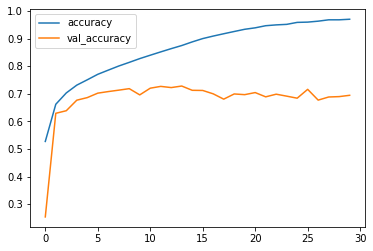

In [27]:
metrics[['accuracy', 'val_accuracy']].plot()

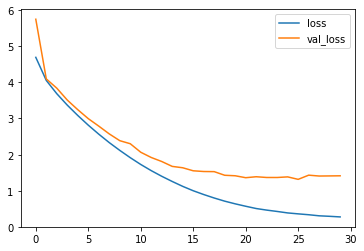

In [28]:
metrics[['loss', 'val_loss']].plot()

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

In [30]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)

In [31]:
y_pred

array([8, 4, 4, ..., 4, 8, 8])

In [32]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1388
           1       1.00      0.82      0.90      1038
           2       0.71      0.37      0.48       661
           3       0.58      0.73      0.64       503
           4       0.54      0.84      0.66       674
           5       0.46      0.54      0.50       501
           6       0.59      0.54      0.56       811
           7       0.33      0.40      0.36       344
           8       0.75      0.73      0.74      1260

    accuracy                           0.69      7180
   macro avg       0.65      0.65      0.64      7180
weighted avg       0.72      0.69      0.70      7180



In [33]:
print(confusion_matrix(y_pred, y_test))

[[1199    0    0   38  129    0   20    0    2]
 [   2  847    0    0  189    0    0    0    0]
 [   5    0  242   50    3  108   52  121   80]
 [   0    0    9  365   16   57   29    9   18]
 [  24    0    1   20  564    2   39   14   10]
 [  94    0   45    4    3  272   15   62    6]
 [   6    0    0  117   51    3  436   21  177]
 [   0    0   29    1   11  139   10  139   15]
 [   8    0   13   39   69   11  140   55  925]]
